<a href="https://colab.research.google.com/github/RoxieCardonax/LeafIdentification/blob/main/VGG16_Health_20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.0. Install Dependencies and Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install tensorflow opencv-python matplotlib

In [3]:
!pip install scikit-learn

In [4]:
!pip list

Package                          Version
-------------------------------- ---------------------
absl-py                          1.4.0
aiohttp                          3.8.6
aiosignal                        1.3.1
alabaster                        0.7.13
albumentations                   1.3.1
altair                           4.2.2
anyio                            3.7.1
appdirs                          1.4.4
argon2-cffi                      23.1.0
argon2-cffi-bindings             21.2.0
array-record                     0.5.0
arviz                            0.15.1
astropy                          5.3.4
astunparse                       1.6.3
async-timeout                    4.0.3
atpublic                         4.0
attrs                            23.1.0
audioread                        3.0.1
autograd                         1.6.2
Babel                            2.13.1
backcall                         0.2.0
beautifulsoup4                   4.11.2
bidict                           0.22.1
b

In [5]:
!pip install keras

In [6]:
import tensorflow as tf
import os

In [7]:
#Only use 50% of GPU
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Oct 28 01:25:04 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    56W / 400W |    677MiB / 40960MiB |      5%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 1.1. Remove Dodgy Image

In [8]:
import cv2
import imghdr # allows to check file extensions
from matplotlib import pyplot as plt

In [9]:
data_dir = '/content/drive/MyDrive/leafhealth/resize_data' #variable to hold path to data directory

In [10]:
image_extensions = ['jpeg','jpg', 'bmp', 'png'] #list of standard image file extensions

In [11]:
# for loop - looping through directory and then every image to check if they can be used by cv2 and imghdr if not then they are removed
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path) #not a valid image
            tip = imghdr.what(image_path) #not a valid image extension
            if tip not in image_extensions:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

In [12]:
#How many classes are there?
num_classes = 0

#Iterate Directory
for path in os.listdir(data_dir):
    num_classes += 1
print ('File count:', num_classes)


File count: 2


# 2.0. Load Data

In [13]:
import numpy as np
from matplotlib import pyplot as plt

In [14]:
#Build the data pipeline
data = tf.keras.utils.image_dataset_from_directory(
    '/content/drive/MyDrive/leafhealth/data',
    labels='inferred',
    label_mode='binary',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 4502 files belonging to 2 classes.


In [15]:
data_iterator = data.as_numpy_iterator() #access the generator from data pipeline - allowing us to loop through data pipeline

In [16]:
batch = data_iterator.next() #accessing the data piepline itself

/usr/local/lib/python3.10/dist-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


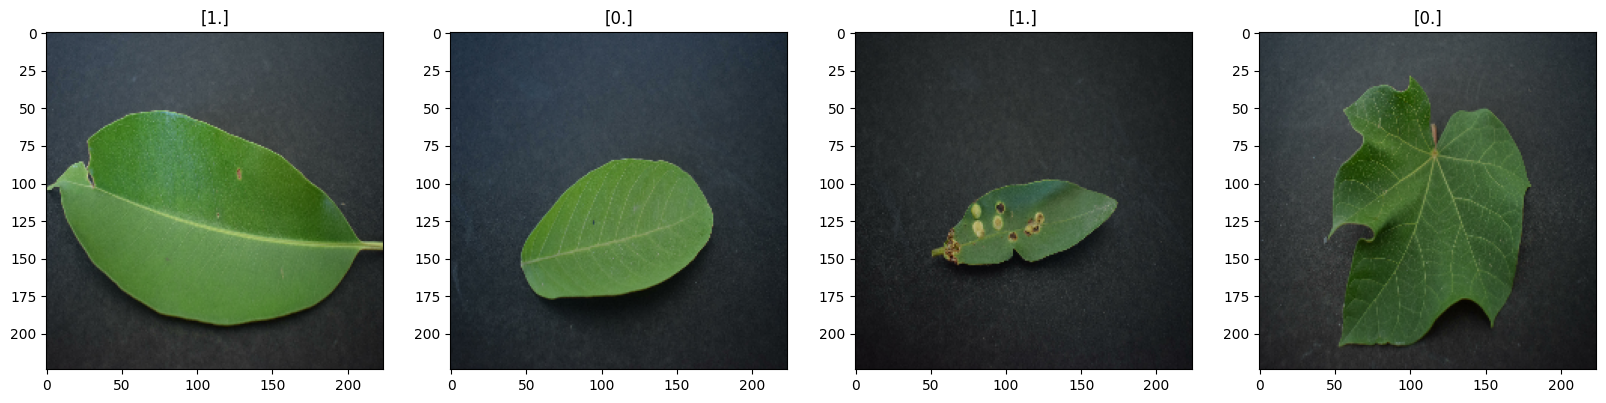

In [17]:
# for loop - looping through the images and classifying them as healthy = 0 and unhealthy = 1
#shows the classifications 0=healthy, 1 = unhealthy
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 3.0. Pre-Processing Data

## 3.1. Scale Data

In [18]:
data = data.map(lambda x,y: (x/255, y)) #map - applies a particular transformation as data is being preprocessed by the data pipeline... x = images, y = target values

In [19]:
scaled_iterator=data.as_numpy_iterator()

In [20]:
batch = scaled_iterator.next()

In [21]:
#CHECK FOR BATCH MAX AND MIN 0 - 1
#batch [0].min()
batch [0].max()

0.9788507

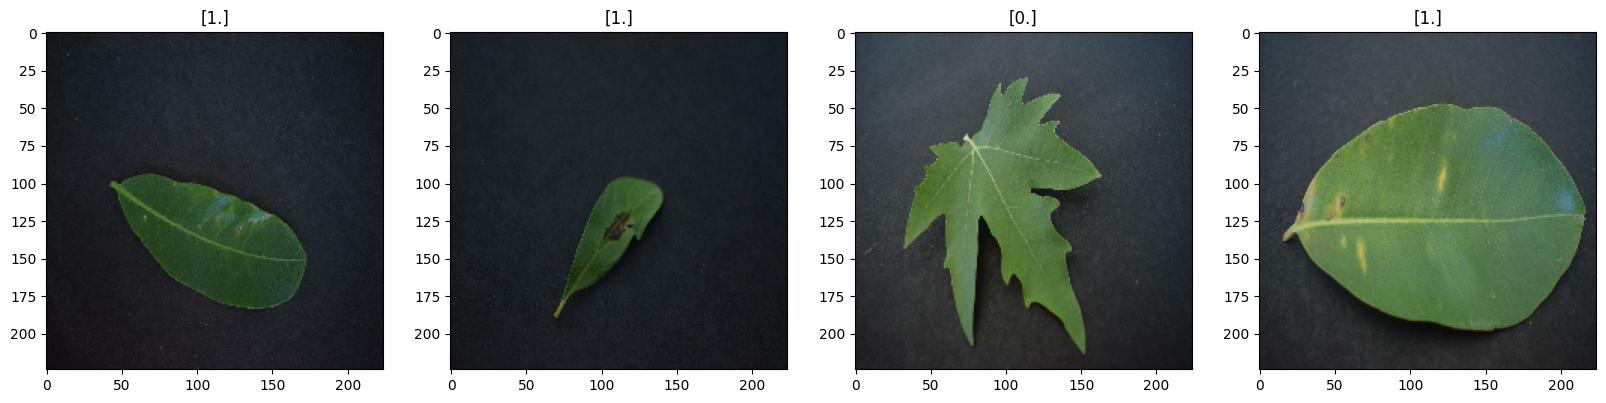

In [22]:
#CHECK IF IMAGES ARE LOADED AND SCALED
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])
    #shows the classifications unhealthy = 1 and healthy = 0

## 3.2. Split Data

In [23]:
#Partitian Allocation
train_size = int((len(data)*.7)) #training will be 70% of data
val_size = int((len(data)*.2)) #20% for validation
test_size = int((len(data)*.1+1)) #10% testing + 1 because the data is an uneven number

In [24]:
#CHECK that it is equal to length
train_size+val_size+test_size

142.0

In [25]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [26]:
len(test)

15

# 4.0. Deep Learning Model

## 4.1. Load VGG16 Model

In [27]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2



In [28]:
l2_strength = 0.01  # You can adjust this value as needed

In [29]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

58889256/58889256 [==============================] - 4s 0us/step


In [30]:
# Freeze the pre-trained layers to prevent them from being updated during training
for layer in base_model.layers:
    layer.trainable = False

In [31]:
# Add custom classification layers on top of VGG16
x = Flatten()(base_model.output)
x = Dense(512, activation='relu', kernel_regularizer=l2(l2_strength))(x)  # Add L2 regularization
x = Dropout(0.5)(x)  # Optional: Add dropout for regularization
output = Dense(1, activation='sigmoid')(x)  # Binary classification output


In [32]:
# Create the model
model = Model(inputs=base_model.input, outputs=output)

In [33]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [34]:
# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.01),  # Adjust the learning rate as needed
    loss='binary_crossentropy',  # Binary cross-entropy for binary classification
    metrics=['accuracy']
)

## 4.2. Train

In [35]:
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import EarlyStopping

In [36]:
logdir='logs'

In [37]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
# Define the early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Quantity to be monitored (validation loss)
    patience=10,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

In [38]:
hist = model.fit(train, epochs=20, validation_data=val) #fit is the training function

Epoch 1/20
98/98 [==============================] - 333s 3s/step - loss: 6.0092 - accuracy: 0.7146 - val_loss: 3.1589 - val_accuracy: 0.7868
Epoch 2/20
98/98 [==============================] - 79s 782ms/step - loss: 2.2786 - accuracy: 0.8052 - val_loss: 1.7374 - val_accuracy: 0.8225
Epoch 3/20
98/98 [==============================] - 78s 776ms/step - loss: 1.4887 - accuracy: 0.8256 - val_loss: 1.3298 - val_accuracy: 0.8237
Epoch 4/20
98/98 [==============================] - 78s 771ms/step - loss: 1.1651 - accuracy: 0.8543 - val_loss: 1.1138 - val_accuracy: 0.8292
Epoch 5/20
98/98 [==============================] - 78s 774ms/step - loss: 0.9947 - accuracy: 0.8546 - val_loss: 0.9735 - val_accuracy: 0.8225
Epoch 6/20
98/98 [==============================] - 78s 774ms/step - loss: 0.8572 - accuracy: 0.8658 - val_loss: 0.8575 - val_accuracy: 0.8292
Epoch 7/20
98/98 [==============================] - 78s 775ms/step - loss: 0.7732 - accuracy: 0.8635 - val_loss: 0.7975 - val_accuracy: 0.8214
E

## 4.3. Plot Performance

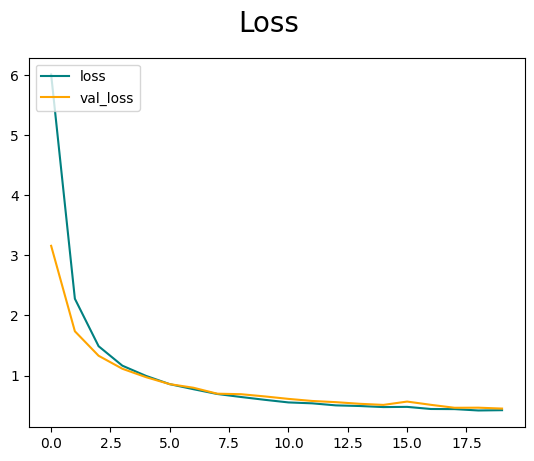

In [39]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

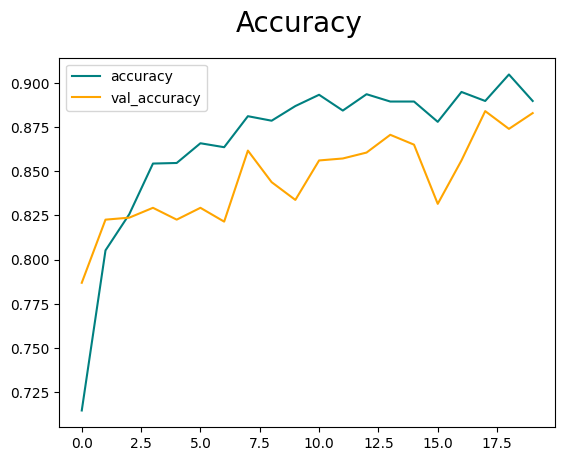

In [40]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 5.0 Evaluate

In [41]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [42]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [43]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 1s 796ms/step


In [44]:
print(f'Precision:{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy: {acc.result().numpy()}')

Precision:0.9078947305679321, Recall:0.8884119987487793, Accuracy: 0.8999999761581421


## 5.1 Predications

In [45]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [46]:
test_labels = y

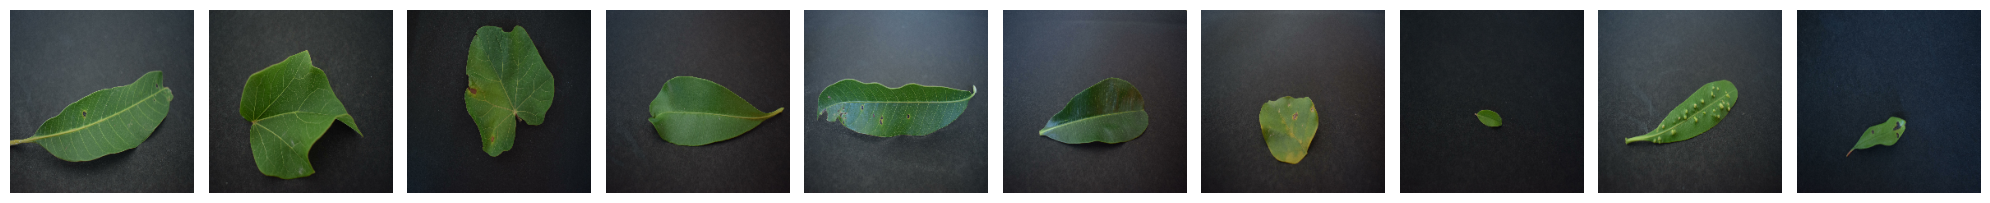

[[1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]]


In [47]:
plotImages(X)
print(test_labels)

In [48]:
predictions = yhat

In [72]:
flatten_pred = predictions.flatten()

In [73]:
flatten_pred

array([0.9758566 , 0.20243046, 0.8300025 , 0.07484849, 0.24491051,
       0.6523131 , 0.9235502 , 0.10339357, 0.99967635, 0.8496579 ,
       0.99053603, 0.43238193, 0.2337118 , 0.8985767 , 0.7555878 ,
       0.05658182, 0.22473013, 0.12096901, 0.99370766, 0.9984547 ,
       0.8394202 , 0.14540032], dtype=float32)

In [74]:
# Convert to 0 and 1
round_pred=[]

for x in flatten_pred:
    if x < 0.5:
        x=0
    else:
        x=1
    round_pred.append(x)

In [75]:
round_pred=np.array(round_pred)

In [76]:
round_pred

array([1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0])

In [77]:
test_labels

array([[1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.]], dtype=float32)

## 5.2 Confusion Matrix

In [78]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import itertools
import matplotlib.pyplot as plt

In [79]:
cm = confusion_matrix(y_true=test_labels, y_pred=round_pred)

In [80]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [81]:
cm_plot_labels = ['healthy','unhealthy']

Confusion matrix, without normalization
[[ 7  2]
 [ 3 10]]


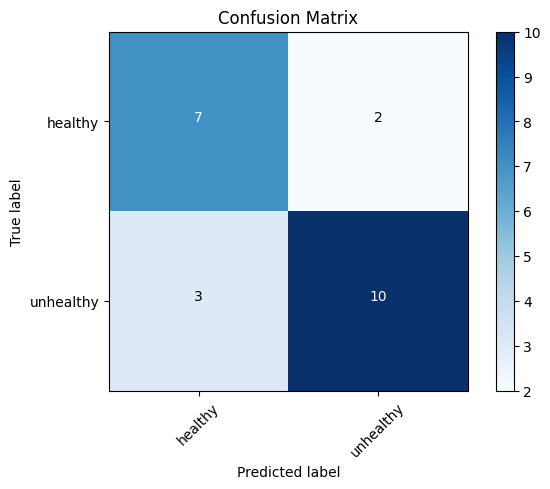

In [82]:
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [85]:
# Example usage:
accuracy = accuracy_score(test_labels, round_pred)
precision = precision_score(test_labels, round_pred)
recall = recall_score(test_labels, round_pred)
f1 = f1_score(test_labels, round_pred)
confusion = confusion_matrix(test_labels, round_pred)

In [86]:
accuracy

0.7727272727272727

In [87]:
precision

0.8333333333333334

In [88]:
recall

0.7692307692307693

In [89]:
f1

0.8

# 6.0 Test

In [ ]:
import cv2
from matplotlib import pyplot as plt

TypeError: ignored

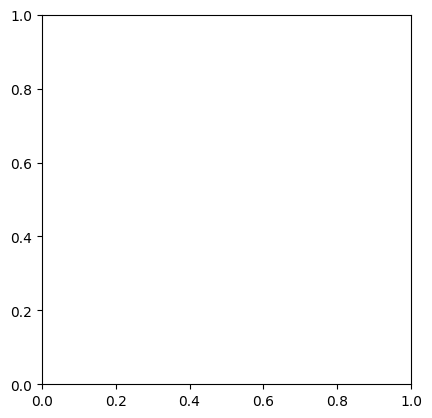

In [ ]:
img = cv2.imread('healthy_test.jpg')
plt.imshow(img)
plt.show()

In [ ]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [ ]:
yhat = model.predict(np.expand_dims(resize/255, 0))

In [ ]:
yhat

In [ ]:
if yhat > 0.5:
    print(f'Predicted class is Unhealthy')
else:
    print(f'Predicted class is Healthy')

# 7.0 Save Model

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
model.save(os.path.join('models','leafhealth.h5'))

In [ ]:
new_model = load_model('models/leafhealth.h5')

In [ ]:
new_model.predict(np.expand_dims(resize/255, 0))

In [ ]:
#Verify that laoded model has the same achitecture and weights as the saved model
new_model.summary()

# 8.0 Augmentation

NEED TO ADJUST SO THAT WHEN RUN THROUGH ONCE IT AUGMENTS ALL THE DATA

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
%matplotlib inline

In [ ]:
chosen_image = random.choice(os.listdir('data/healthy'))

In [ ]:
image_path = 'data/healthy/' + chosen_image

In [ ]:
image = np.expand_dims(plt.imread(image_path),0)
plt.imshow(image[0])

In [ ]:
gen = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, height_shift_range=0.1, shear_range=0.15, zoom_range=0.1,
    channel_shift_range=10., horizontal_flip=True)

In [ ]:
aug_iter = gen.flow(image)
aug_images = [next(aug_iter)[0].astype(np.uint8) for i in range(10)]

In [ ]:
plotImages(aug_images)

In [ ]:
aug_iter = gen.flow(image, save_to_dir='data/healthy', save_prefix='aug-image-', save_format='jpeg')